In [14]:
import numpy as np
import window as w
import psychoac as p
import matplotlib.pyplot as plt
import mdct as m
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

## Encoder Methods

In [95]:
def calcSpecEnv(data,cutoff,fs):
    # calcSpecEnv - Function to calculate spectral envelope passed to decoder for SBR
    # data:      input signal for current block
    # cutoff:    Cutoff frequency in Hz
    # fs:        Sampling rate in Hz

    N = data.size
    freqVec = np.arange(0,fs/2,fs/float(N)) # Vector of FFT bin frequencies
    Xn = np.fft.fft(w.HanningWindow(data),N)
    hannWin = (1/float(N))*np.sum(np.power(w.HanningWindow(np.ones_like(data)),2)) # Get avg pow of hann window
    XnI = (4/(np.power(N,2)*hannWin))*(np.power(np.abs(Xn),2)) # Compute values of FFT intensity
    
    bandLimits = p.cbFreqLimits # Zwicker critical band upper limits
    cutBand = np.argwhere(bandLimits>=cutoff)[0] # Next band limit above cutoff freq
    nHfBands = len(bandLimits)-cutBand # How many bands will be reconstructed
    
    specEnv = np.zeros(nHfBands-1)
    for i in range(nHfBands-1):
        bandLines = np.intersect1d(np.argwhere(freqVec>bandLimits[cutBand+i]),\
                                   np.argwhere(freqVec<=bandLimits[cutBand+i+1]))
        highMean = np.mean(XnI[bandLines])
        subBand = XnI[i*len(bandLines):(i+1)*len(bandLines)]
        subMean = np.mean(subBand)
        # Spec Env is ratio of avg intensity in each hi-freq critical band to corresponding sub band
        specEnv[i]=highMean/subMean      
    specEnv[np.nonzero(np.isnan(specEnv))] = 1 # Get rid of pesky nans
        
    return specEnv

## Decoder Methods

In [4]:
# High Frequency Reconstruction
def HiFreqRec(mdctLines,fs,cutoff):
    nMDCT = len(mdctLines)
    cutBin = freqToBin(nMDCT,cutoff,fs)
    lowerBand = mdctLines[0:cutBin]
    mdctLines[cutBin+1:cutBin+len(lowerBand)+1] = lowerBand # Do the transposition

    return mdctLines.astype(float) # If these are ints it can cause problems

In [5]:
# Additional High Frequency Components
def AddHiFreqs(mdctLines,fs,cutoff):
    nMDCT = len(mdctLines)
    cutBin = freqToBin(nMDCT,cutoff,fs)
    noiseBins = len(mdctLines[cutBin:])
    mdctLines[cutBin:] *= np.absolute(np.random.normal(1,0.5,noiseBins))# Add some noise to reconstructed bins
#     mdctLines[cutBin:] *= 0.2 # Hardcoding this hack until envelope is ready
    return mdctLines

In [101]:
# Envelope Adjustment (assumes HF Reconstruction has occured)
def EnvAdjust(mdctLines,fs,envelope):
    nMDCT = len(mdctLines)
    mdctFreq = np.arange(0,fs/2,fs/float(N))+(fs/float(2.*N))
    bandLimits = p.cbFreqLimits # Zwicker critical band upper limits
    cutBand = np.argwhere(bandLimits>=cutoff)[0] # Next band limit above cutoff freq
    nHfBands = len(envelope)
    tempLines = np.copy(mdctLines)
    
    for i in range(nHfBands):
        # Find MDCT lines in this critical band and apply envelope from encoder
        bandLines = np.intersect1d(np.argwhere(mdctFreq>bandLimits[cutBand+i]),\
                                   np.argwhere(mdctFreq<=bandLimits[cutBand+i+1]))
        bandInt = np.mean(tempLines[bandLines]) # Average intensity in current band
        tempLines[bandLines] *= envelope[i]        
    return tempLines

## Utility

In [60]:
# Utility Function to Convert Cutoff Freq to Bin number
def freqToBin(nMDCT,cutoff,fs):
    N = 2*nMDCT
    freqVec = np.arange(0,fs/2,fs/float(N))+fs/float(2.*N) # MDCT Frequencies
    cutBin = np.argmin(np.absolute(freqVec-cutoff)) # Find index of cutoff frequency
    return cutBin

In [75]:
# Utility Function to Convert cutoff frequency to 
def freqToBand(cutoff):
    bandLimits = p.cbFreqLimits # Zwicker critical band upper limits
    cutBand = np.argwhere(bandLimits>=cutoff)[0] # Next band limit above cutoff freq
    
    return cutBand

## Test Code

10.1191072458
9.23085221181
9.4276548542
Band:  [21] Freq [9500]
Spec Env:  [ 0.70681841  1.34606315  1.02479762]


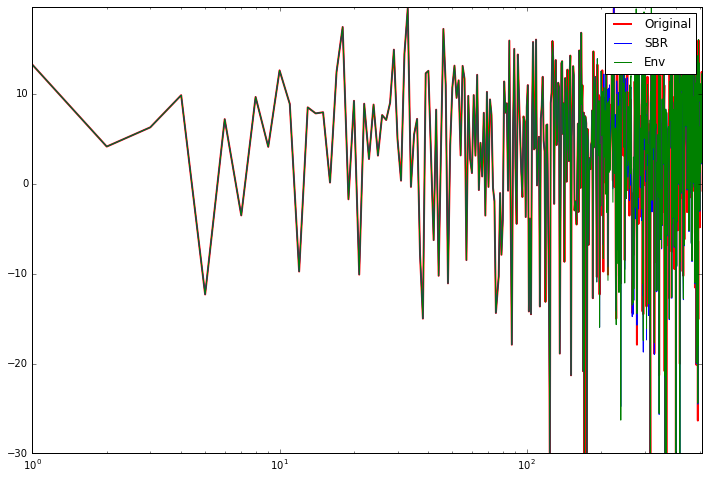

In [100]:
#-----------------------------------------------------------------------------

#Testing code
if __name__ == "__main__": 
    fs = 48000
    T = 1/float(fs)
    N = 1024
    n = np.arange(0,N*T,T)
    freqVec = np.arange(0,fs/2,fs/float(N)) # Vector of frequencies for plotting
    freqMDCT = freqVec + (fs/float(2.*N)) # MDCT Lines
    
#     # Test Signal from previous hw
#     A = np.array([0.40,0.20,0.20,0.09,0.06,0.05]) # Sinusoidal component amplitudes
#     F = np.array([440,550,660,880,4400,8800]) # Sinusoidal frequencies
#     xn = A[0]*np.cos(2*np.pi*F[0]*n) + A[1]*np.cos(2*np.pi*F[1]*n) +\
#     A[2]*np.cos(2*np.pi*F[2]*n) + A[3]*np.cos(2*np.pi*F[3]*n) + \
#     A[4]*np.cos(2*np.pi*F[4]*n) + A[5]*np.cos(2*np.pi*F[5]*n)

#     Noise Signal
    xn = np.random.uniform(-1,1,(N))
    
    Xmdct = m.MDCT(w.SineWindow(xn),N/2,N/2) # Compute FFT of signal
    sineWin = (1/float(N))*np.sum(np.power(w.SineWindow(np.ones_like(xn)),2)) # Get avg pow of hann window
    XmI = (4/(np.power(N,2)*sineWin))*(np.power(np.abs(Xmdct),2)) # Convert values of FFT to intensity
    
    cutoff = 9000
    
    specEnv = calcSpecEnv(xn,cutoff,fs)
    
    newBins = HiFreqRec(XmI,fs,cutoff)
    noiseBins = AddHiFreqs(newBins,fs,cutoff)
    envBins = EnvAdjust(noiseBins,fs,specEnv)

    plt.figure(1)
    plt.semilogx(p.SPL(XmI),color='red',lw=2,label="Original")
    plt.hold(True)
    plt.semilogx(p.SPL(noiseBins),color='blue',lw=1,label="SBR")
    plt.hold(True)
    plt.semilogx(p.SPL(envBins),color='green',lw=1,label="Env")
    plt.hold(True)
    a = plt.gca()
    a.legend()
    a.axis('tight')
    
    print 'Band: ',freqToBand(cutoff),'Freq',p.cbFreqLimits[freqToBand(cutoff)]
    print 'Spec Env: ',specEnv